In [1]:
# note celerite is linear with N, so no benefit to breaking into chunks
# if I wanted to fit two datasets at the same time, I would need to 
# create a new jitter term that has different variances for the the
# different data sets. Harder if assume different amplitudes for two
# datasets.

%matplotlib inline

In [2]:
import emcee
import autograd.numpy as np
import matplotlib.pyplot as plt
from astropy.stats import LombScargle, median_absolute_deviation
from scipy.optimize import minimize
import glob
from tqdm import tqdm
import corner

import celerite
from celerite import terms

from gp import get_rotation_gp
from astropy.io import fits
from statsmodels import robust

do_kep = False
do_kep2 = False
do_test = False

In [3]:

if do_kep:
    f = fits.open('../data/kplr009726699-2010203174610_slc.fits') 
    hdu_data = f[1].data

    t = hdu_data["time"]
    y = hdu_data["sap_flux"]/np.nanmedian(hdu_data["sap_flux"])-1
    yerr = hdu_data["sap_flux_err"]/np.nanmedian(hdu_data["sap_flux"])

    ninc = 5000
    rand = 0 #np.random.randint(0,len(t)-ninc)
    t = t[rand:rand+ninc]
    y = y[rand:rand+ninc]
    yerr = yerr[rand:rand+ninc]

    name = f[0].header['OBJECT'].replace(' ','')

elif do_kep2:
    f = fits.open('../data/kplr009726699-2009350155506_llc.fits') 
    hdu_data = f[1].data

    t = hdu_data["time"]
    y = hdu_data["sap_flux"]/np.nanmedian(hdu_data["sap_flux"])-1
    yerr = hdu_data["sap_flux_err"]/np.nanmedian(hdu_data["sap_flux"])

    ninc = 5000
    rand = 0 #np.random.randint(0,len(t)-ninc)
    t = t[rand:rand+ninc]
    y = y[rand:rand+ninc]
    yerr = yerr[rand:rand+ninc]

    name = f[0].header['OBJECT'].replace(' ','')
    
elif do_test:
    
    t, y = np.genfromtxt('/Volumes/Mimas/full_dataset/final/lightcurve_0289.txt',
                        unpack=True)
    y = y/np.median(y) - 1.
    err_est = robust.mad(np.diff(y)) 
    ## should multiple by 1.48, and then divide by sqrt(2) so pretty much good as is
    yerr = np.ones_like(y)*err_est

    ninc = 5000
    rand = 0 #np.random.randint(0,len(t)-ninc)
    t = t[rand:rand+ninc]
    y = y[rand:rand+ninc]
    yerr = yerr[rand:rand+ninc]
    
    name = '0289'
    
else:
    
    t, y, yerr = np.genfromtxt('example_star.csv', delimiter=',', unpack=True)
    name = 'example'


In [4]:
# Do some aggressive sigma clipping
m = np.ones_like(y, dtype=bool)
while True:
    mu = np.nanmean(y[m])
    sig = np.nanstd(y[m])
    m0 = y - mu < 3 * sig
    if np.all(m0 == m):
        break
    m = m0

m = m*np.isfinite(y)*np.isfinite(yerr)*np.isfinite(t)
t_orig, y_orig, yerr_orig = np.copy(t), np.copy(y), np.copy(yerr)
f = lambda x: np.ascontiguousarray(x, dtype=np.float64)
t, y, yerr = map(f, [t[m], y[m], yerr[m]])

(3106, 3106)


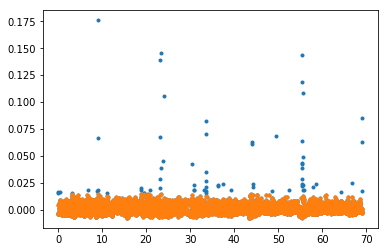

In [5]:
print (len(t_orig), len(y_orig))
plt.plot(t_orig, y_orig, '.')
plt.plot(t, y, '.')
#plt.xlim(320, 330)

0.7106213715271957


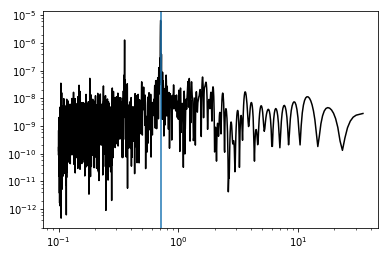

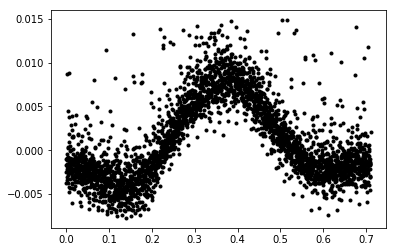

In [6]:
# First guess at the period
fmin = max([2./(t[-1]-t[0]),0.02] )
freq = np.linspace(fmin, 10.0, 5000)
model = LombScargle(t, y)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, "k")
plt.axvline(period)
plt.xscale("log")
plt.yscale("log")

plt.figure()
plt.plot(t % period, y, ".k")


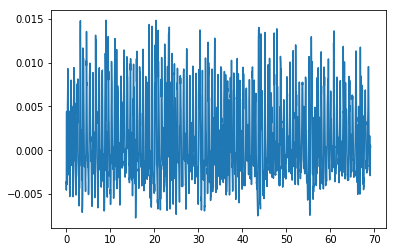

In [7]:
plt.plot(t, y)
#plt.xlim(330, 340)

In [8]:
#t, y, yerr = t_orig, y_orig, yerr_orig
min_period = period * 0.7
max_period = period / 0.7

gp = get_rotation_gp(t, y, yerr,
                     period, min_period, max_period)
gp.compute(t, yerr)
print(gp.log_likelihood(y))
gp.get_parameter_dict()

-4395.25352172


OrderedDict([('kernel:terms[0]:log_S0', -10.759540718855042),
             ('kernel:terms[0]:log_omega0', -0.8162396866239419),
             ('kernel:terms[1]:log_sigma', -8.725982422727876),
             ('kernel:terms[2]:log_a', -10.759540718855042),
             ('kernel:terms[2]:log_Q1', 2.70805020110221),
             ('kernel:terms[2]:mix_par', 4.0),
             ('kernel:terms[2]:log_Q2', 2.70805020110221),
             ('kernel:terms[2]:log_P', -0.3416155205207038)])

OrderedDict([('kernel:terms[0]:log_S0', -18.457657582819643), ('kernel:terms[1]:log_sigma', -6.717119996283927), ('kernel:terms[2]:log_a', -11.85431249291498), ('kernel:terms[2]:log_Q1', 8.130456680233817), ('kernel:terms[2]:mix_par', 4.864579647868322), ('kernel:terms[2]:log_Q2', 0.0)])
(2521, 3039)
OrderedDict([('kernel:terms[0]:log_S0', -14.025834506552396), ('kernel:terms[1]:log_sigma', -7.947220520371017), ('kernel:terms[2]:log_a', -12.140857859912103), ('kernel:terms[2]:log_Q1', 7.851146483161136), ('kernel:terms[2]:mix_par', 4.642155508813351), ('kernel:terms[2]:log_Q2', 0.5202623128672964)])
(2158, 2521)
OrderedDict([('kernel:terms[0]:log_S0', -12.75926422799344), ('kernel:terms[1]:log_sigma', -9.266377495955568), ('kernel:terms[2]:log_a', -11.20856708810082), ('kernel:terms[2]:log_Q1', 8.744621333035902), ('kernel:terms[2]:mix_par', -0.62140349485995), ('kernel:terms[2]:log_Q2', 0.8782232328889009)])
(2004, 2158)
OrderedDict([('kernel:terms[0]:log_S0', -12.055327135517832), ('

OrderedDict([('kernel:terms[0]:log_S0', -10.797028171557788),
             ('kernel:terms[1]:log_sigma', -13.725982422727876),
             ('kernel:terms[2]:log_a', -11.184531043701519),
             ('kernel:terms[2]:log_Q1', 8.30008799854716),
             ('kernel:terms[2]:mix_par', -0.7494246624609916),
             ('kernel:terms[2]:log_Q2', 1.3781716553342584),
             ('kernel:terms[2]:log_P', -0.3422052093999735)])

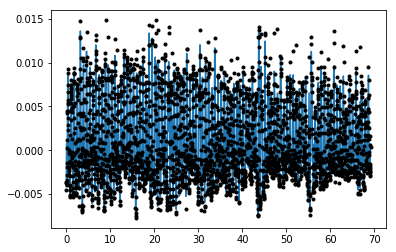

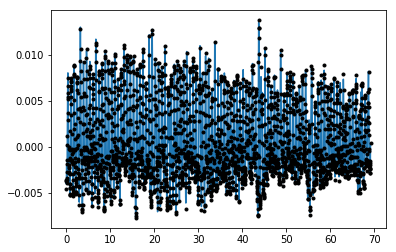

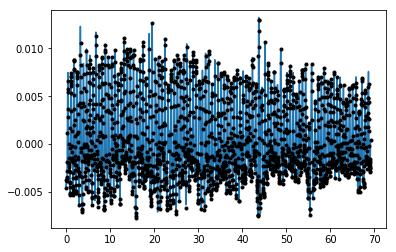

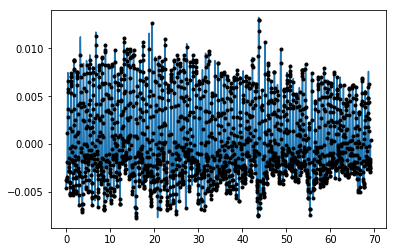

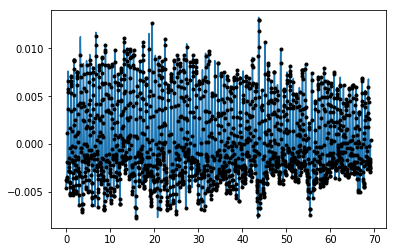

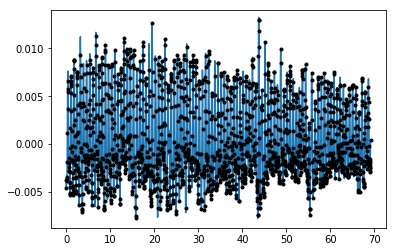

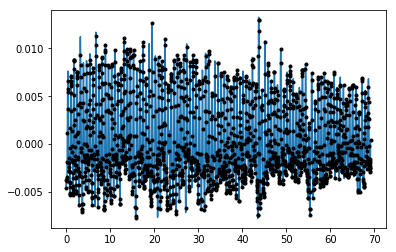

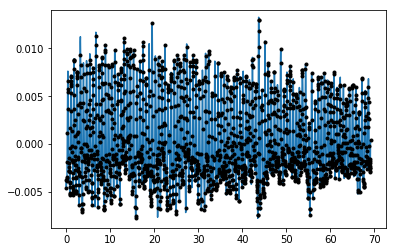

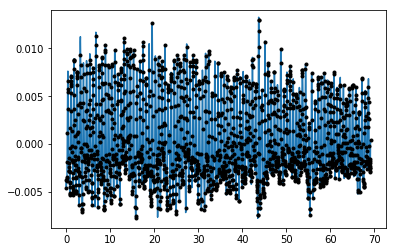

In [9]:
def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]


# Do another round of sigma clipping using the GP model
# freeze the rotation period so it doesn't fit flares
gp.freeze_parameter("kernel:terms[2]:log_P")
#gp.freeze_parameter("kernel:terms[0]:log_S0")
gp.freeze_parameter("kernel:terms[0]:log_omega0")
#gp.freeze_parameter("kernel:terms[1]:log_sigma")
#gp.freeze_parameter("kernel:terms[2]:log_a")
#gp.freeze_parameter("kernel:terms[2]:log_Q2")
#gp.freeze_parameter("kernel:terms[2]:log_Q1")

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# t, y, yerr = t_orig, y_orig, yerr_orig
m = np.ones(len(t), dtype=bool)
for i in range(10):
    plt.figure()
    plt.plot(t[m], y[m], ".k")
    ylim = plt.gca().get_ylim()

    gp.compute(t[m], yerr[m])   ## to figure out the shape of 
                                ## the array and time stamps
                                ## factorizes the covariance matrix
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x) ## this also re-computes
    initial_params = soln.x
    # log_a, logQ1, mix_par, logQ2, log_P
    print(gp.get_parameter_dict())
    mu, var = gp.predict(y[m], t, return_var=True)
    sig = np.sqrt(var + yerr**2)
    plt.plot(t, mu, zorder=0)
    plt.ylim(ylim)
    #plt.ylim(-1,2)
    
    resid = y - mu
    sig = np.sqrt(np.median(resid**2))
    m0 = resid < 1.3 * sig
    print(m0.sum(), m.sum())
    if np.all(m0 == m) or (np.abs(m0.sum()- m.sum()) < 3):
        break
    m = m0
  
gp.thaw_parameter("kernel:terms[2]:log_P")
bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()
gp.compute(t[m], yerr[m])
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp, m))
gp.set_parameter_vector(soln.x)
initial_params = soln.x

fit_t, fit_y, fit_yerr = t[m], y[m], yerr[m]
gp.compute(fit_t, fit_yerr)
gp.log_likelihood(fit_y)   
gp.get_parameter_dict()

ValueError: x and y must have same first dimension, but have shapes (3039,) and (3106,)

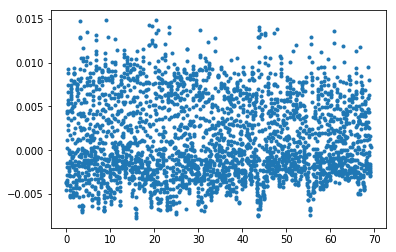

In [20]:
plt.plot(t, y, '.')
plt.plot(t, mu, zorder=0)
plt.xlim(0,10)

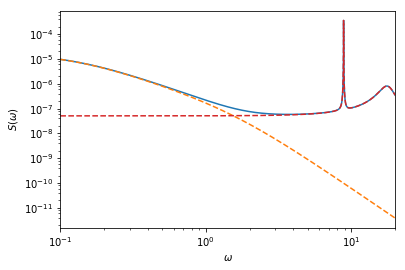

In [11]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [25]:
print soln.x

[-10.79702817 -13.72598242 -11.18453104   8.300088    -0.74942466
   1.37817166  -0.34220521]


In [26]:
def log_prior(params, logperiod):
    lp = gp.log_prior()
    p = gp.get_parameter_dict()['kernel:terms[2]:log_P']
    period = np.exp(logperiod)
    sigma = 0.2
    
    logperiod_half = np.log(period)*2.
    logperiod_twice = np.log(period)/2.
    gaussian_prior = (-1./2.)*((p - logperiod)/(sigma))**2.
    gaussian_prior_half = (-1./2.)*((p - logperiod_half)/(sigma))**2.
    gaussian_prior_twice = (-1./2.)*((p - logperiod_twice)/(sigma))**2.

    lp = lp + 0.5*gaussian_prior + 0.25*gaussian_prior_half + 0.25*gaussian_prior_twice
    
    return lp

def log_prob(params, logperiod):
    gp.set_parameter_vector(params)
    lp = log_prior(params, logperiod)
    if not np.isfinite(lp):
        return -np.inf
#     make the noise budget be dominated by the peroidic signal
#     if (gp.get_)
    return lp + gp.log_likelihood(fit_y)

logperiod = gp.get_parameter_dict()['kernel:terms[2]:log_P']

ndim = len(soln.x)
nwalkers = 32
print(gp.get_parameter_dict()    )

# set up initial positions
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
#lp = np.array(list(map(log_prob, pos)))
lp = np.array( [log_prob(pos_i, logperiod) for pos_i in pos] )
# and make sure none of them are NaNs
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = soln.x + 1e-5 * np.random.randn(m.sum(), ndim)
    #lp[m] = np.array(list(map(log_prob, pos[m])))
    lp[m] = np.array( [log_prob(pos_i, logperiod) for pos_i in pos[m]] )
    m = ~np.isfinite(lp)



OrderedDict([('kernel:terms[0]:log_S0', -10.756993774177577), ('kernel:terms[1]:log_sigma', -12.882484825192579), ('kernel:terms[2]:log_a', -11.471739661766255), ('kernel:terms[2]:log_Q1', 8.416447348963832), ('kernel:terms[2]:mix_par', -0.26618100624817465), ('kernel:terms[2]:log_Q2', 1.383011065445354), ('kernel:terms[2]:log_P', -0.34220497028154434)])


In [27]:
args=[logperiod]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=args)
pos, _, _ = sampler.run_mcmc(pos, 500)


In [14]:
sampler.reset()
sampler.run_mcmc(pos, 1000);

In [28]:
m = np.isfinite(y_orig)*np.isfinite(yerr_orig)*np.isfinite(t_orig)
mle = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
gp.set_parameter_vector(mle)
mu, var = gp.predict(fit_y, t_orig[m], return_var=True)
std = np.sqrt(yerr_orig[m]**2 + var)


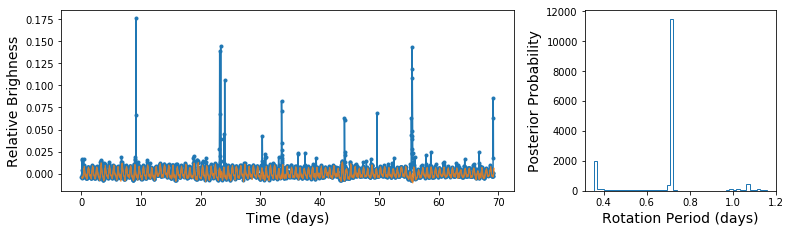

In [29]:
pdist = np.exp(sampler.flatchain[:, 6])
pbest = np.median(pdist)
               
fig = plt.figure(figsize=[11,6])
color = "#ff7f0e"

ax1 = plt.subplot2grid((2, 3), (1, 0), colspan=2, )
ax2 = plt.subplot2grid((2, 3), (1, 2), colspan=1, )

ax1.fill_between(t_orig[m], mu+std*3, mu-std*3, alpha=0.7, color=color, zorder=1)
ax1.plot(t_orig, y_orig, '.-', zorder=0)
#ax1.set_ylim(-0.02,0.03)
xl = [t_orig[0], t_orig[-1]]
if (xl[1]-xl[0]) > 5*pbest:
    xl = [t_orig[0], t_orig[0]+5*pbest]
#ax1.set_xlim(260,262)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Brighness', fontsize=14)

ax2.hist(pdist, 50, histtype="step")
ax2.set_xlabel('Rotation Period (days)', fontsize=14)
ax2.set_ylabel('Posterior Probability', fontsize=14)

fig.tight_layout()

In [ ]:
gp.get_parameter_dict()

In [ ]:
varnames = gp.get_parameter_dict().keys()
samples = sampler.chain[:, :, :].reshape((-1, ndim)) 
best = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]], \
                   zip(*np.percentile(samples, [16, 50, 84], axis=0))) ## arranged: [50th, uppe
mydict = {}
labels = [None]*ndim
for i in range(len(varnames)):
    vv = varnames[i][16:]
    if vv == 'mix_par':
        vv = 'mix'
    else:
        vv = vv.replace('log_','log(')+')'
    mydict[vv] = best[i]
    labels[i] = vv
mydict

In [ ]:
'kernel:terms[0]:'.replace('ker','v')

In [ ]:
std

In [ ]:
var